In [266]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose
from sklearn.preprocessing import MinMaxScaler


In [267]:
#read dataset

hf = h5py.File('/Users/DELL/Downloads/Project2/Data/ML_WORKSHOP_Kolmogorov_Re30_T1000_DT001.h5','r')

learnrate = 0.0001
Nx = 24 # Nx=24 for Re=20 or Re=30; Nx=48 for Re=40
Nu = 2
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
#if Nu==2:
u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
#hf.close()
print(u_all.shape)

(10000, 24, 24, 2)


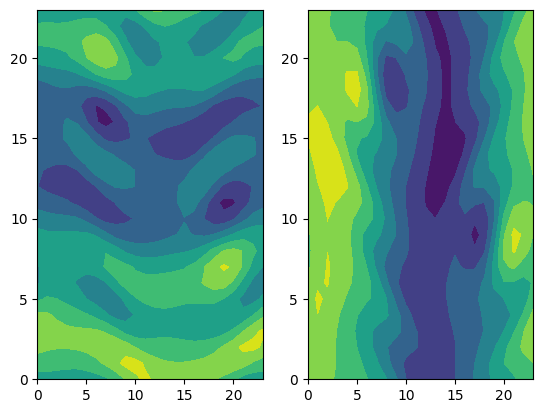

In [268]:
# visualization of the dataset
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[0,:,:,0])
#plt.colorbar(ax=ax)
ax2 = fig.add_subplot(122)
ax2.contourf(u_all[0,:,:,1])

In [269]:
#choosing a test data set to assess the accuracy of our model
Ntrain = int(np.round(0.9*len(u_all)))
print(Ntrain)
u_all_train=u_all[:Ntrain,:,:,:]
print(u_all_train.shape)
u_all_test=u_all[Ntrain:,:,:,:]

9000
(9000, 24, 24, 2)


In [270]:
input_layer = tf.keras.Input(shape=(Nx, Nx, 2))

# Defining the encoder

x=tf.keras.layers.Conv2D(10,(3,3),activation='relu')(input_layer)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(5,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.4)(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(2,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)

encoded=x=tf.keras.layers.MaxPooling2D((2,2))(x)

# defining the decoder


x=tf.keras.layers.UpSampling2D((2,2))(encoded)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(5,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(10,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)

decoded=tf.keras.layers.Conv2DTranspose(2,(3,3),activation='linear')(x)



# defining the autoencoder

autoencoder=tf.keras.Model(input_layer,decoded)
autoencoder.summary()

Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 24, 24, 2)]       0         
                                                                 
 conv2d_150 (Conv2D)         (None, 22, 22, 10)        190       
                                                                 
 batch_normalization_455 (Ba  (None, 22, 22, 10)       40        
 tchNormalization)                                               
                                                                 
 conv2d_151 (Conv2D)         (None, 20, 20, 5)         455       
                                                                 
 batch_normalization_456 (Ba  (None, 20, 20, 5)        20        
 tchNormalization)                                               
                                                                 
 dropout_68 (Dropout)        (None, 20, 20, 5)         0  

In [271]:
# We use the adam optimizer for our first prediction

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learnrate),loss='mse')

In [272]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min', verbose=1,restore_best_weights=True )

hist = autoencoder.fit(u_all_test,u_all_test,batch_size=10,epochs=1000,validation_split=0.25, callbacks=[early_stop_callback])
loss_history = hist.history['loss']

Epoch 1/1000
75/75 [==============================] - 5s 21ms/step - loss: 1.2915 - val_loss: 0.1432
Epoch 2/1000
75/75 [==============================] - 1s 17ms/step - loss: 0.7506 - val_loss: 0.1639
Epoch 3/1000
75/75 [==============================] - 1s 17ms/step - loss: 0.4682 - val_loss: 0.1826
Epoch 4/1000
75/75 [==============================] - 1s 19ms/step - loss: 0.3377 - val_loss: 0.2036
Epoch 5/1000
75/75 [==============================] - 1s 17ms/step - loss: 0.2666 - val_loss: 0.2134
Epoch 6/1000
75/75 [==============================] - 1s 16ms/step - loss: 0.2179 - val_loss: 0.1984
Epoch 7/1000
75/75 [==============================] - 1s 16ms/step - loss: 0.1797 - val_loss: 0.1776
Epoch 8/1000
75/75 [==============================] - 1s 16ms/step - loss: 0.1487 - val_loss: 0.1611
Epoch 9/1000
75/75 [==============================] - 1s 17ms/step - loss: 0.1261 - val_loss: 0.1447
Epoch 10/1000
75/75 [==============================] - 1s 15ms/step - loss: 0.1088 - val_lo

KeyboardInterrupt: 

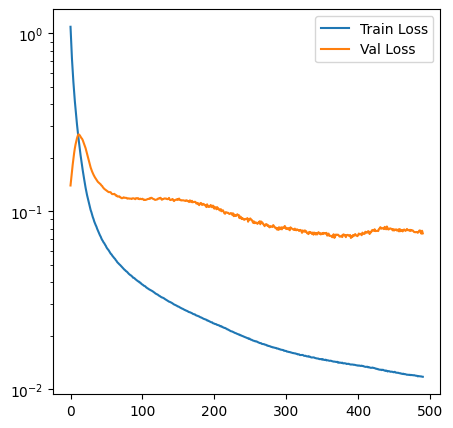

In [ ]:
# we evaluate the loss for this model

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(5,5))
labels = ["Train Loss", "Val Loss"]
lines1, = plt.semilogy(loss, label= "training loss")
lines2, = plt.semilogy(val_loss, label= "validation loss") 

handles = [lines1, lines2]

plt.legend(handles, labels)
plt.show()


32/32 [==============================] - 1s 10ms/step


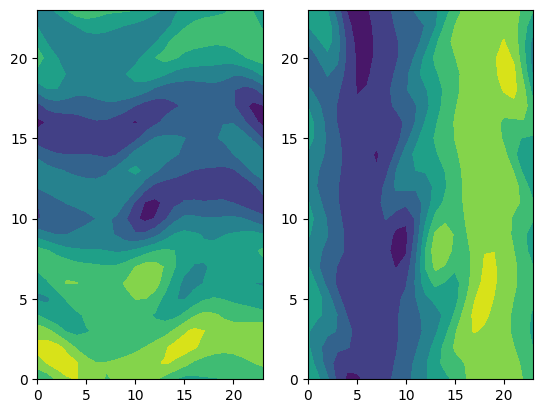

In [ ]:
reconstructed_images=autoencoder.predict(u_all_test[:,:])
# visualization of the results
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all_test[0,:,:,0])
#plt.colorbar(ax=ax)
ax2 = fig.add_subplot(122)
ax2.contourf(u_all_test[0,:,:,1])
plt.show()

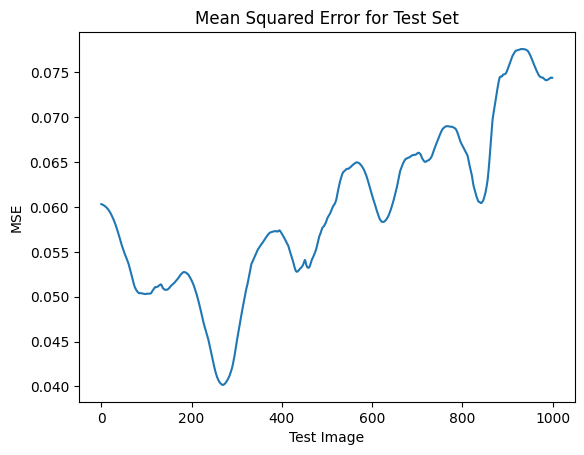

In [ ]:
# Calculate the mean squared error between the original and reconstructed images for the test data
mse = np.mean(np.square(u_all_test - reconstructed_images), axis=(1, 2, 3))

# Plot the mean squared error for each test image
plt.plot(mse)
plt.title("Mean Squared Error for Test Set")
plt.xlabel("Test Image")
plt.ylabel("MSE")
plt.show()

# 9. Proper Orthogonal Decomposition

In [ ]:
# Separate images for u and v components
u_all_u = u_all[:,:,:,0]

u_all_v = u_all[:,:,:,1]


# reshape into 2D
U = tf.reshape(u_all_u, [10000, 576])

V = tf.reshape(u_all_v, [10000,576])


# Transpose snapshot matrix
U_transpose = np.transpose(U)

V_transpose = np.transpose(V)


#Compute covariance matrix
C = np.matmul(U_transpose, U)*(1/9999)

C2 = np.matmul(V_transpose, V)*(1/9999)

In [ ]:
# Solve eigenproblem
eigenvalues,eigenvectors=eig(C)

#plt.plot(eigenvalues)

eigenvalues_v,eigenvectors_v=eig(C2)


# Arrange eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

idx2 = eigenvalues_v.argsort()[::-1]   
eigenvalues_v = eigenvalues_v[idx2]
eigenvectors_v = eigenvectors_v[:,idx2]

In [ ]:
igenvectors_T = np.transpose(eigenvectors)
eigenvectors_T2 = np.transpose(eigenvectors_v)

#Compute A Matrix
A = np.matmul(U, eigenvectors)
print(A.shape)

#Number of modes
k=81


# Add k modes
first_col = A[:,0:k]
print(first_col.shape)

first_row = eigenvectors_T[0:k,:]
print(first_row.shape)

test=np.matmul(first_col,first_row)
print(test.shape)


A2 = np.matmul(V, eigenvectors_v)

first_col_v = A2[:,0:k]

first_row_v = eigenvectors_T2[0:k,:]

test2=np.matmul(first_col_v,first_row_v)



U_tilde = tf.reshape(test, [10000,24,24])

V_tilde = tf.reshape(test2, [10000,24,24])

In [ ]:
# visualization of the reconstructed and the original image
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(U_tilde[0,:,:])
plt.title("Number of Modes = 81")

ax2 = fig.add_subplot(122)
ax2.contourf(u_all[0,:,:,0])
plt.title("Original Image")






fig2 = plt.figure()
ax = fig2.add_subplot(121)
ax.contourf(V_tilde[0,:,:])

plt.title("Number of modes = 81")
ax2 = fig2.add_subplot(122)

ax2.contourf(u_all[0,:,:,1])
plt.title("Original Image")

In [ ]:
mse_POD_u = np.mean(np.square(u_all_u - U_tilde), axis=(1, 2))
mse_POD_v = np.mean(np.square(u_all_v - V_tilde), axis=(1, 2))
plt.plot( mse_POD_u, label="u component")
plt.plot( mse_POD_v, label = "v component")
plt.legend(loc='upper left')
plt.xlabel("Mode")
plt.ylabel("MSE")
plt.show()